In [2]:
import os
import cv2
import json
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [47]:
def normalize_bounding_boxes(json_data):
    image_width = json_data['image']['width']
    image_height = json_data['image']['height']

    for annotation in json_data['annotations']:
        bbox = annotation['bounding_box']
        bbox['h'] /= image_height
        bbox['w'] /= image_width
        bbox['x'] /= image_width
        bbox['y'] /= image_height

    return json_data

def get_class_file_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    classes = []
    for line in lines:
        elements = line.split()
        class_id = int(elements[0])
        classes.append(class_id)
        bbox = [float(e) for e in elements[1:]]
        bboxes.append(bbox)
    return np.array(classes), np.array(bboxes)


def get_json_file_data(json_file_path:os.PathLike):
    with open(json_file_path, 'r') as file:
        json_data = json.load(file)
    
    return json_data

def segment_json_to_numpy(json_file_path:os.PathLike, get_image_shape:bool=True):
    json_data = get_json_file_data(json_file_path)
    bboxes = []
    for segment in json_data['annotations']:
        box = segment['bounding_box']
        bboxes.append([box['x'], box['y'], box['w'], box['h']])
    
    if get_image_shape:
        return np.array(bboxes), (json_data['image']['height'], json_data['image']['width'])

def xywh2xyxy(boxes:np.ndarray):
    assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    # boxes[:, 0] -= boxes[:, 2]/2
    # boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes

def xcycwh2xyxy(boxes:np.ndarray):
    assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    boxes[:, 0] -= boxes[:, 2]/2
    boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes 
   
def normalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] /= width
    xyxy_boxes[:, 2] /= width
    xyxy_boxes[:, 1] /= height
    xyxy_boxes[:, 3] /= height
    
    return xyxy_boxes


def denormalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] *= width
    xyxy_boxes[:, 2] *= width
    xyxy_boxes[:, 1] *= height
    xyxy_boxes[:, 3] *= height
    
    return xyxy_boxes.astype(int)
  
def rectangles_on_image(image:np.ndarray,
                        boxes:np.ndarray,
                        classes:list = None,
                        box_color:tuple=(255, 0, 0),
                        label_color:tuple=(0, 0, 0),
                        
                        thickness:int=5):
    for box in boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(image, (x1,y1), (x2,y2), box_color, thickness)
    
    if classes is not None:
        for i, tooth_class in enumerate(classes):
            cv2.putText(image, str(tooth_class), (boxes[i][:2]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, label_color, 10)
        
    return image


def get_closest_box_index(box:np.ndarray, target_boxes:np.ndarray):
    # Aoverlap=(max(l0,l1)−min(r0,r1))⋅(max(t0,t1)−min(b0,b1)).
    # x_overlap = Math.max(0, Math.min(rect1.right, rect2.right) - Math.max(rect1.left, rect2.left));
    # y_overlap = Math.max(0, Math.min(rect1.bottom, rect2.bottom) - Math.max(rect1.top, rect2.top));
    # overlapArea = x_overlap * y_overlap;
    overlap_areas = []
    # rect1.left = box[0] rext1.top = box[1]
    # rect2.left = target_box[0] rext2.top = target_box[1]
    # rect1.right = box[2] rext1.bottom = box[3]
    # rect2.right = target_box[2] rext2.bottom = target_box[3]
    
    for target_box in target_boxes:
        x_overlap = max(0, min(box[2],target_box[2] ) - max(box[0], target_box[0]))
        y_overlap = max(0, min(box[3], target_box[3]) - max(box[1], target_box[1]))
        overlap_areas.append(x_overlap*y_overlap)
    
    closest_box_index = np.argmax(overlap_areas)
    
    return closest_box_index
    
def get_box_matching_mask(target_boxes, boxes_to_match):
    # assert abs(boxes_to_match.shape[0]-target_boxes.shape[0])==0, "The number of target and matching boxes should be the same"
    mask = []
    for box_to_match in boxes_to_match:
        closest_box_index = get_closest_box_index(box_to_match, target_boxes)
        mask.append(closest_box_index)
        
    return mask

def get_segmentations(json_file_path:os.PathLike, get_image_shape:bool=True):
    
    json_data = get_json_file_data(json_file_path)
    for tooth_data in json_data['annotations']:
        path = tooth_data['polygon']['path']
        segment = np.array([[point['x'], point['y']] for point in path])
    if get_image_shape:
        return segment
    
def normalize_segmentations(polygon, img_shape):

    polygon[::2] /= img_shape[1]
    polygon[1::2] /= img_shape[0]
    polygon = np.clip(polygon, 0, 1)
  
    return polygon

def write_txt_file(txt_file_path, class_id, polygon):
    
    with open(txt_file_path, 'a') as file:
        file.write(f'{class_id}')
        for point in polygon:
            file.write(f" {point}")
        file.write('\n')



In [4]:
class_files_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels")
json_root_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations")
output_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations_classes")
image_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\images")

In [5]:
json_file_paths = list(json_root_path.glob("*.json"))

In [16]:
for json_file_path in json_file_paths:
    if not json_file_path.exists():
        break
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    target_boxes = xcycwh2xyxy(target_boxes)
    
    box_matching_mask = get_box_matching_mask(segmentation_boxes, target_boxes)
    
    print(box_matching_mask)
    segmentation_boxes = segmentation_boxes[box_matching_mask]
    for i, segmentation_box in enumerate(segmentation_boxes):
        print(target_classes[i], segmentation_box)
        break
    print(len(segmentation_boxes))
    print(target_classes)
    break
    segmentation_classes = target_classes
    
    # image = cv2.imread(str(image_path))
    
    # plt.subplots(1,2, figsize=(20, 5))
    # plt.suptitle(image_path)
    # plt.subplot(1,2,1)
    # plt.title("Ours")
    # plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(segmentation_boxes, img_shape), segmentation_classes))
    # plt.subplot(1,2,2)
    # plt.title("Sepuh's")
    # plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(target_boxes, img_shape), target_classes))
    # plt.show()


[3, 4, 2, 1, 24, 22, 21, 20, 19, 18, 17, 16, 8, 10, 11, 12, 13, 9, 14, 15, 25, 23, 0, 7, 6, 5]
6 [0.23201935 0.23416154 0.28087742 0.46071538]
26
[ 6  5  4  3 31 30 29 28 27 26 25 24 16 17 18 19 20 21 22 23 14 13  2 12
 11 10]


In [54]:
from natsort import natsorted
json_file_paths = natsorted(json_file_paths)
print(json_file_paths)

[WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/1.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/2.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/3.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/4.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/5.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/6.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/7.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/8.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/9.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/10.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/11.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/12.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/13.json'), WindowsPath('C:/Users/AMET/DocGaid/yolov8/data/annotations/14.json'), WindowsPath('C:/Users/AMET/D

In [71]:
prediction_labels = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\new_single_tooth\\prediction_labels") 
count = 0
for json_file_path in json_file_paths:
    # print(json_file_path)
    if not json_file_path.exists():
        break
    
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    target_boxes = xcycwh2xyxy(target_boxes)
    
    box_matching_mask = get_box_matching_mask(segmentation_boxes, target_boxes)
    
    # print(len(box_matching_mask))
    
    segmentation_boxes = segmentation_boxes[box_matching_mask]
    # print(len(segmentation_boxes))
    segmentations = get_segmentations(json_file_path)
    print(segmentations.shape)
    # break
    segmentations = segmentations[box_matching_mask]
    # print(img_shape)
    destination_file_path = (prediction_labels/json_file_path.stem).with_suffix(".txt")
    for i in range(len(segmentations)):
        
        flattened_segmentations = segmentations.flatten()
        # print(flattened_segmentations)
        # break
        normalized_segmentations = normalize_segmentations(flattened_segmentations, img_shape)
        # write_txt_file(destination_file_path, target_classes[i], normalized_segmentations)
    #     # print(target_classes[i])
        # print(normalized_segmentations)
        # break
        
    # break
    # flattened_segmentations = segmentations.flatten()
    # # print(len(segmentations))
    # # print(segmentations)
    # # break
    # segmentation_classes = target_classes
    
    # image = cv2.imread(str(image_path))
    
    # plt.subplots(1,2, figsize=(20, 5))
    # plt.suptitle(image_path)
    # plt.subplot(1,2,1)
    # plt.title("Ours")
    # plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(segmentation_boxes, img_shape), segmentation_classes))
    # plt.subplot(1,2,2)
    # plt.title("Sepuh's")
    # plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(target_boxes, img_shape), target_classes))
    # plt.show()


(50, 2)
(50, 2)
(45, 2)
(27, 2)
(41, 2)
(39, 2)
(25, 2)
(62, 2)
(46, 2)
(58, 2)
(29, 2)
(50, 2)
(54, 2)
(32, 2)
(27, 2)


IndexError: index 31 is out of bounds for axis 0 with size 27

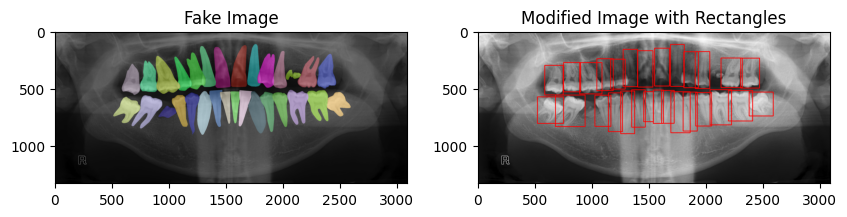

In [ ]:
from random import randint

def get_segmentation_polygon(json_file_path:os.PathLike):
    segment = []
    json_data = get_json_file_data(json_file_path)
    for tooth_data in json_data['annotations']:
        path = tooth_data['polygon']['path']
        segment.append([[point['x'], point['y']] for point in path])
    
    return segment

for json_file_path in json_file_paths[28:29]:
    if not json_file_path.exists():
        break
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    target_classes, target_boxes = get_class_file_data(class_file_path)
    target_boxes = xcycwh2xyxy(target_boxes)
    
    plt.show()
   
    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)

    segmentation = get_segmentation_polygon(json_file_path)
    image = cv2.imread(str(image_path))
    
    layer = np.zeros_like(image)

    alpha = 0.5  # Define the alpha for blending

    for segment in segmentation:
        ctr = np.array(segment, dtype=np.int32)
        color = (randint(0, 255), randint(0, 255), randint(0, 255))

        # Fill the polygon in the layer
        cv2.fillPoly(layer, [ctr], color=color)

        # Blend the original image with the layer
        fake_image = cv2.addWeighted(image, alpha, layer, 1-alpha, 0)

    # Display the image
    plt.figure(figsize=(10, 5))

# Display the first image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(fake_image)
    plt.title("Fake Image")

    # Display the second image on the right
    plt.subplot(1, 2, 2)
    plt.imshow(rectangles_on_image(image.copy(), denormalize_boxes(target_boxes, img_shape)))
    plt.title("Modified Image with Rectangles")

    plt.show()
    